# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
# # ! python -m pip install --upgrade pip
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# # ! pip install --upgrade --force-reinstall torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1
# # (use --upgrade --force-reinstall to upgrade)

# ! pip install scikit-image
# ! pip install matplotlib
# ! pip install opencv-python
# ! pip install setuptools
# ! pip install --upgrade --force-reinstall transformers==4.36.0
# ! pip install transformers
# ! pip install tensorflow
# ! pip install tf-keras
# ! pip show transformers
# ! pip show transformers


In [2]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json

from collections import OrderedDict

import torch
import torch.nn as nn
import pandas as pd

from sklearn.model_selection import train_test_split

from pkg_resources import packaging

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\AlexTerentowicz\AppData\Local\Temp\ipykernel_1304\3818302515.py:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)
print(torch. cuda. is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.3.0+cu118
True
CUDA version: 11.8


# Loading the model

In [4]:
from transformers import pipeline

ekman = pipeline('sentiment-analysis', model='arpanghoshal/EkmanClassifier')

ekman_test_output = ekman("Thanks for using it.")

print(ekman_test_output)

e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new dow

[{'label': 'joy', 'score': 0.9997512698173523}]


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import json

frame_types = ["frame_first", "frame_half", "frame_last", "comic_3", "comic_4"]

def vid_path(filename):
    return f'./data/video/train/{filename}'

def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

def load_utt(vid_no, utt_no, text_data):
    utt = text_data[vid_no]['conversation'][utt_no-1]
    vid = load_video(vid_path(utt['video_name']))
    return vid, utt

def load_frame(fname, frame_type):
    path = f'./data/preproc/{frame_type}/{fname}.jpg'
    frame = cv2.imread(path)
    return frame

def frame_to_img(frame):
    # frame = Image.fromarray(frame).convert("RGB")
    # frame = Image.fromarray(np.array(frame)[:, :, ::-1])
    
    frame = Image.fromarray(frame[:, :, ::-1])
    return  frame

with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

# Prepare data

In [6]:
with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

# list of video filenames
texts = []
video_fnames_list = []
n_utts = 0
labels = []

for c_id, conv in text_data.items():
    n_utts += len(conv['conversation'])
    for utt in conv['conversation']:
        # u_id = utt['utterance_ID']
        texts.append(utt['text'])
        labels.append(utt['emotion'])
        video_fnames_list.append(utt['video_name'])

print(len(video_fnames_list), n_utts)

13619 13619


In [7]:
print(texts[:3])
print(labels[:3])

['Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .', 'Oh , yeah . Had that dream .', 'Then I look down , and I realize there is a phone ... there .']
['neutral', 'neutral', 'surprise']


Split the dataset

In [8]:
train_indices, test_indices = train_test_split(range(len(video_fnames_list)), test_size=0.2, random_state=42)

# lengths
print(len(train_indices), len(test_indices))

# create a list of video filenames, X_train, X_test, Y_train, Y_test

train_video_fnames = [video_fnames_list[i] for i in train_indices]
test_video_fnames = [video_fnames_list[i] for i in test_indices]

# split texts and labels by indices
train_texts = [texts[i] for i in train_indices]
test_texts = [texts[i] for i in test_indices]

train_labels = [labels[i] for i in train_indices]
test_labels = [labels[i] for i in test_indices]

10895 2724


In [9]:
# value counts of test labels
test_labels_counts = pd.Series(test_labels).value_counts()
test_labels_counts

neutral     1211
joy          480
surprise     342
anger        294
sadness      226
fear          89
disgust       82
Name: count, dtype: int64

# Classify
## Zero-shot classification

In [10]:
ekman_test_output = ekman(test_texts)
ekman_test_output[:3]

[{'label': 'neutral', 'score': 0.8762741088867188},
 {'label': 'anger', 'score': 0.8076923489570618},
 {'label': 'neutral', 'score': 0.9764866232872009}]

In [11]:
# create a list of labels
test_predicted_labels = []

for e in ekman_test_output:
    test_predicted_labels.append(e['label'])

print(set(test_predicted_labels))
print(set(test_labels))

{'fear', 'disgust', 'surprise', 'neutral', 'sadness', 'anger', 'joy'}
{'fear', 'disgust', 'surprise', 'neutral', 'sadness', 'joy', 'anger'}


In [26]:
?sns.heatmap

Signature:
sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise

In [31]:
import matplotlib

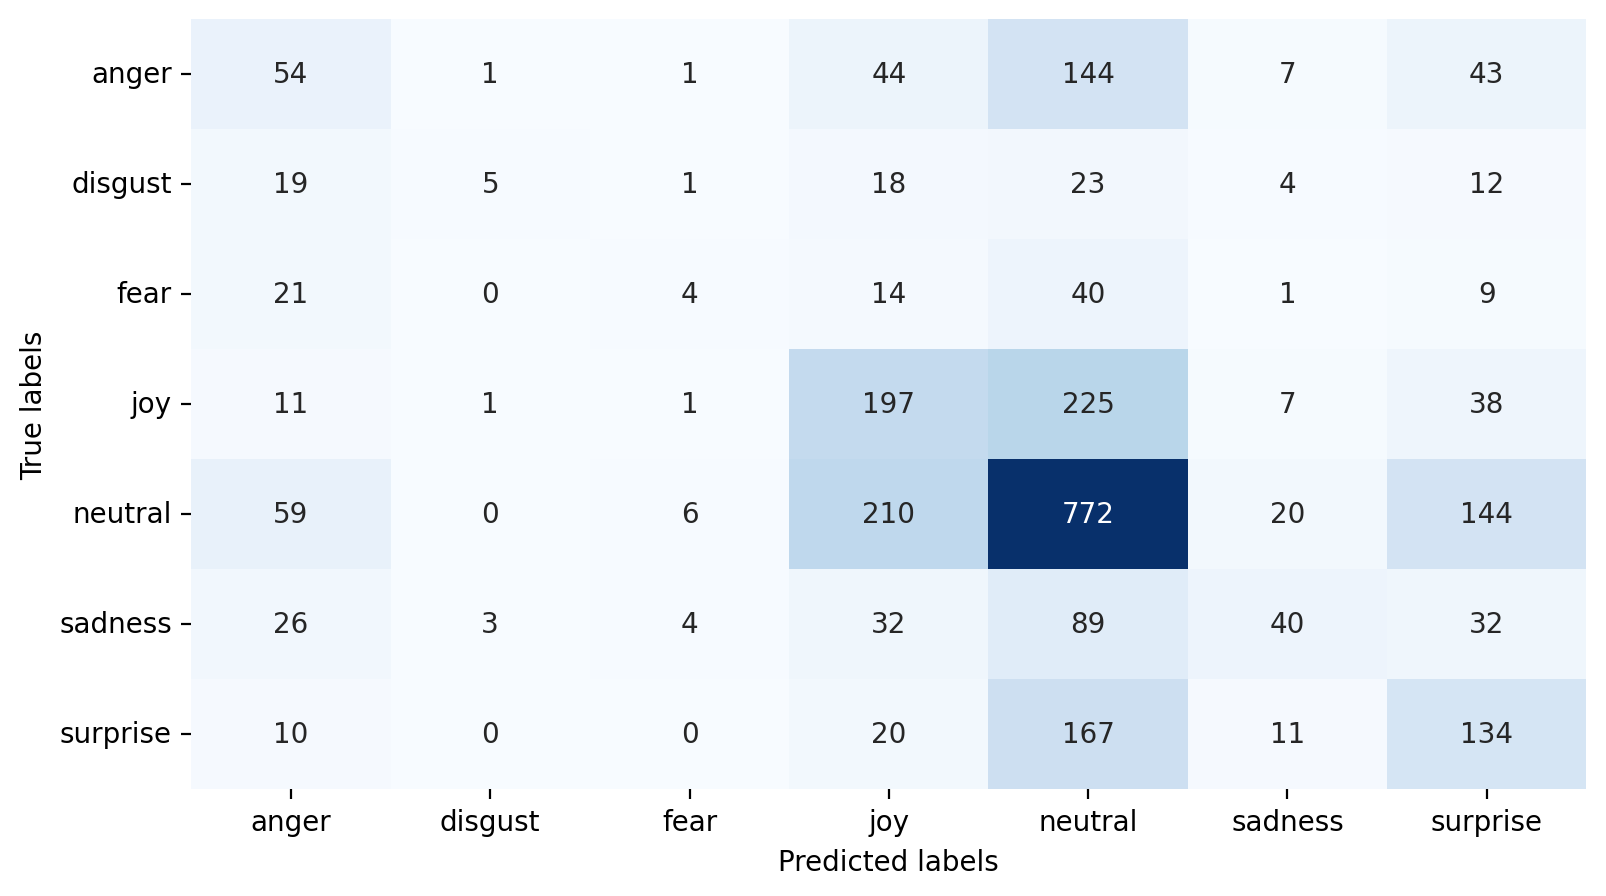

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.rc('figure', figsize=(9, 5))

labels_ordered = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

cm = confusion_matrix(test_labels, test_predicted_labels, labels=labels_ordered)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_ordered, yticklabels=labels_ordered, cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(f'./experiments/plots/EkmanClassifier/confusion_matrix.png')
plt.show()

In [15]:
# count accuracy, f1 micro and f1 macro
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(test_labels, test_predicted_labels)
f1_micro = f1_score(test_labels, test_predicted_labels, average='micro')
f1_macro = f1_score(test_labels, test_predicted_labels, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 micro: {f1_micro}')
print(f'F1 macro: {f1_macro}')

Accuracy: 0.44273127753303965
F1 micro: 0.44273127753303965
F1 macro: 0.2825187208794145


In [15]:
print(test_predicted_labels[:10])
print(test_labels[:10])

['neutral', 'anger', 'neutral', 'joy', 'neutral', 'anger', 'anger', 'joy', 'surprise', 'neutral']
['joy', 'disgust', 'anger', 'neutral', 'neutral', 'neutral', 'sadness', 'neutral', 'neutral', 'joy']
